Here is an example use-case of the cluster_expand.py library

In this notebook, we initialize a mixed Lennard Jones crystal lattice system and calculate energies of configurations minimized at zero pressure. We then fit these energies to a cluster expansion.

First, import some necessary modules. Numpy will be used to create the lattice, matplotlib will be used to visualize the fitting, lammps will be used to calculate energies of configurations, and cluster_expand will be used to perform the fitting.

lattice_parameter is the lattice parameter of the initialized lattice
box_length is the size of the supercell (box_length x box_length x box_length)
num_samples is the number of configurations we sample and calculate energies for
num_types is the number of atomic types in the lattice
interaction_order is the furthest neighbor shell we include in the fitting
num_epochs is the number of steps when we optimize in the fitting procedure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lammps

from cluster_expand import ClusterExpansion, CubicLattice

lattice_parameter = 1.6
box_length = 7
num_samples = 10
num_types = 3
interaction_order = 2
num_epochs = 10_000

We'll initialize an fcc lattice with the appropriate atomic basis and 1nn/2nn distances, as well as some necessary padding for periodic boundary conditions. We can then immediately calculate the adjacency tensor.

In [2]:
fcc_lattice = CubicLattice(
    lattice_parameter=lattice_parameter,
    dimensions=(box_length, box_length, box_length),
    atomic_basis=[
        [0.0, 0.0, 0.0], 
        [0.5, 0.5, 0.0], 
        [0.5, 0.0, 0.5], 
        [0.0, 0.5, 0.5]
    ],
    first_nearest=lattice_parameter / np.sqrt(2.0),
    second_nearest=lattice_parameter,
    pbc_padding=[0.5 * box_length, 0.5 * box_length, 0.5 * box_length]
)
    
adjacency_tensor = fcc_lattice.get_order_two_adjacency_tensor(tolerance=0.01)

Then, we create some configuration matrices. Each configuration will be roughly equiatomic - you can change this by passing in a p variable into the np.random.choice call, which will bias the sampling according to specified probabilities/compositions

In [3]:
all_occupation_numbers = np.zeros((fcc_lattice.num_sites, num_types, num_samples))

for sample in np.arange(num_samples, dtype=int):
    occupation_numbers = np.zeros((fcc_lattice.num_sites, num_types))
    for site in np.arange(fcc_lattice.num_sites, dtype=int):
        type_ = np.random.choice(np.arange(num_types, dtype=int))
        occupation_numbers[site, type_] = 1.0
    all_occupation_numbers[:, :, sample] = occupation_numbers

Here, the magic happens, where we calculate the potential energy of a given configuration on a lattice. For different use cases, this function will significantly differ. In our case, this function creates a LAMMPS-style data file with site IDs and positions, minimizes that resulting configuration, and returns the total potential energy.

We then calculate the potential energy of each configuration stored in the configurations tensor above

In [4]:
def get_potential_energy(occupation_numbers_, lattice):
    
    num_sites, num_types_ = occupation_numbers_.shape
    
    lines = [
        'Data file written from configuration array',
        '',
        f'{num_sites:.0f} atoms',
        f'{num_types:.0f} atom types',
        '',
        f'0.0 {lattice.bounds[0]} xlo xhi',
        f'0.0 {lattice.bounds[1]} ylo yhi',
        f'0.0 {lattice.bounds[2]} zlo zhi',
        'Masses',
        '',
        '1 1.0',
        '2 1.0',
        '3 1.0',
        '',
        'Atoms # atomic',
        ''
    ]
    
    for site_index, occupation_vector, lattice_position in zip(lattice.ids, occupation_numbers_, lattice.sites):
        
        if occupation_vector[0] == 1.0:
            occupying_type = 1
        elif occupation_vector[1] == 1.0:
            occupying_type = 2
        elif occupation_vector[2] == 1.0:
            occupying_type = 3
        else:
            raise ValueError
        
        lines.append(f'{site_index + 1:.0f} {occupying_type:.0f} {lattice_position[0]} {lattice_position[1]} {lattice_position[2]} 0 0 0')
        
    lines.append('')
    lines.append('Velocities')
    lines.append('')
    
    for site_index in lattice.ids:
        
        lines.append(f'{site_index + 1} 0 0 0')
        
    with open('lammps.dat', 'w') as file:
        file.writelines([line + '\n' for line in lines])
        
    lmp = lammps.lammps()
    lmp.command('units lj')
    lmp.command('read_data lammps.dat')
    lmp.command('pair_style lj/cut 2.8')
    lmp.command('pair_coeff 1 1 1.0 1.0 2.8')
    lmp.command('pair_coeff 2 2 1.1 1.05 2.8')
    lmp.command('pair_coeff 3 3 1.05 1.1 2.8')
    lmp.command('min_style cg')
    lmp.command('min_modify dmax 1.0e-3 line quadratic')
    lmp.command('fix press_rel all box/relax iso 0.0 vmax 0.001')
    lmp.command('minimize 0.0 1.0e-8 10000 1000000')
    
    energy = lmp.get_thermo('pe')
    lmp.close()
    
    return energy
    
energies = np.zeros(num_samples)
for sample in np.arange(num_samples, dtype=int):
    energies[sample] = get_potential_energy(all_occupation_numbers[:, :, sample], fcc_lattice)

LAMMPS (2 Aug 2023 - Update 1)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (13.9 13.9 13.9)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1372 atoms
  reading velocities ...
  1372 velocities
  read_data CPU = 0.006 seconds
Generated 3 of 3 mixed pair_coeff terms from geometric mixing rule
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.1
  ghost atom cutoff = 3.1
  binsize = 1.55, bins = 9 9 9
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style    : lj
  Current step  : 0
 (src/src/min.cpp:225)
Per MPI rank memory allocation (min/avg/max) = 4.287 | 4.287 | 4.287 Mbytes
   Step          Temp          E_pair         E_m

Then, we fit our data to a cluster expansion model and plot the results

In [5]:
expansion = ClusterExpansion(all_occupation_numbers, energies, adjacency_tensor, interaction_order, num_epochs)
eq_defects, losses, interaction_matrix = expansion.fit()

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ 100.0% symmetry rmse (energy units): 2.12E-06, fitting rmse (energy units): 4.46E+00
Final iteration rmse (energy units): 4.46E+00
Symmetrized rmse (energy units): 4.46E+00


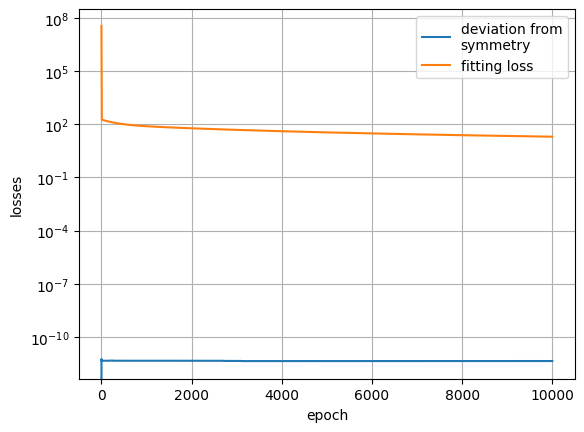

In [6]:
plt.plot(eq_defects, label='deviation from\nsymmetry')
plt.plot(losses, label='fitting loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

We can see that the fitting has definitely not yet converged. Increase the number of steps (and the number of samples) for a real use-case.

Here's the interaction matrix for the 1nn pairs...

In [7]:
print(interaction_matrix[:, :, 0])

[[-0.10460225 -0.14446545  0.15401918]
 [-0.14446545 -0.25996208  0.0675848 ]
 [ 0.15401918  0.0675848  -0.24566674]]


...and for the 2nn pairs.

In [8]:
print(interaction_matrix[:, :, 1])

[[-0.15873726  0.04251345  0.04704443]
 [ 0.04251345  0.48924798  0.23715654]
 [ 0.04704443  0.23715654 -0.06887168]]
